In [6]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Load Datasets

In [20]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

## **Arabic Dataset Evaluation**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#arabic_df = pd.read_csv("/content/drive/MyDrive/arabic_train.csv")
arabic_df = pd.read_csv("/content/drive/MyDrive/ar_hf.csv")

In [9]:
arabic_df

,text,labels,source,dataset,nb_annotators,post_author_country_location
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,0.0,Twitter,L-HSAB,3,unknown
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,0.0,Twitter,L-HSAB,3,unknown
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,0.0,Twitter,L-HSAB,3,unknown
3,وليد جنبلاط كاتب الحكمة يا قذر,0.0,Twitter,L-HSAB,3,unknown
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,0.0,Twitter,L-HSAB,3,unknown
...,...,...,...,...,...,...
449073,@USER روما محظوظين بذا المدرب بيروتي يسحب في ر...,0.0,Twitter,OSACT,3,unknown
449074,@USER هلا والله بالحب<LF>هلا لولو❤️😙<LF>...<LF...,0.0,Twitter,OSACT,3,unknown
449075,رينز فاز 😡😡😡😡😡😡😡 يعنني اوه شوفو العرض الأسطوري...,0.0,Twitter,OSACT,3,unknown
449076,@USER ييييع والله شيء يلوع الكبد مريضات الله ي...,0.0,Twitter,OSACT,3,unknown


In [10]:
arabic_df['text'][2139]

'عماد عثمان قاهر ابواق النظام السوري ولما وئام الحمار يحكي '

In [11]:
arabic_df.columns

Index(['text', 'labels', 'source', 'dataset', 'nb_annotators',
       'post_author_country_location'],
      dtype='object')

In [12]:
arabic_df['labels'].value_counts()

,count
labels,
0.0,432532
1.0,16546


In [34]:
#keep non offensive columns
non_hate_arabic_text = arabic_df[arabic_df['labels'] == 0]
non_hate_arabic_text["hatespeech"] = 0
non_hate_arabic_text = non_hate_arabic_text[["text", "hatespeech"]]
non_hate_arabic_text = non_hate_arabic_text.reset_index(drop= True)
non_hate_arabic_text["language"] = "arabic"
non_hate_arabic_text["target"] = "not hate"
non_hate_arabic_text["directness"] = "normal"
non_hate_arabic_text["annotator_sentiment"] = "normal"
non_hate_arabic_text["group"] = "normal"

/tmp/ipython-input-34-1621198657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_hate_arabic_text["hatespeech"] = 0


In [35]:
non_hate_arabic_text

,text,hatespeech,language,target,directness,annotator_sentiment,group
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,0,arabic,not hate,normal,normal,normal
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,0,arabic,not hate,normal,normal,normal
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,0,arabic,not hate,normal,normal,normal
3,وليد جنبلاط كاتب الحكمة يا قذر,0,arabic,not hate,normal,normal,normal
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,0,arabic,not hate,normal,normal,normal
...,...,...,...,...,...,...,...
432527,@USER روما محظوظين بذا المدرب بيروتي يسحب في ر...,0,arabic,not hate,normal,normal,normal
432528,@USER هلا والله بالحب<LF>هلا لولو❤️😙<LF>...<LF...,0,arabic,not hate,normal,normal,normal
432529,رينز فاز 😡😡😡😡😡😡😡 يعنني اوه شوفو العرض الأسطوري...,0,arabic,not hate,normal,normal,normal
432530,@USER ييييع والله شيء يلوع الكبد مريضات الله ي...,0,arabic,not hate,normal,normal,normal


In [36]:
# keep 5000 rows
non_hate_arabic_text = non_hate_arabic_text.sample(n=5000, random_state=42)
non_hate_arabic_text = non_hate_arabic_text.reset_index(drop = True)
non_hate_arabic_text

,text,hatespeech,language,target,directness,annotator_sentiment,group
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0,arabic,not hate,normal,normal,normal
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0,arabic,not hate,normal,normal,normal
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0,arabic,not hate,normal,normal,normal
3,اي كذبه فيهم,0,arabic,not hate,normal,normal,normal
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0,arabic,not hate,normal,normal,normal
...,...,...,...,...,...,...,...
4995,انو الهوت دوج صار من تاريخ امريكا الحديث,0,arabic,not hate,normal,normal,normal
4996,ولا احكي لما اجيب اغراض من كارفور و يكون من ال...,0,arabic,not hate,normal,normal,normal
4997,لا ول داومي اررح نتاخر بلييييز الي زمان ما شفت...,0,arabic,not hate,normal,normal,normal
4998,بحضر اليوفي واللعيبة قاعدين,0,arabic,not hate,normal,normal,normal


# **French Dataset**

In [15]:
import pandas as pd

french_df = pd.read_csv("/content/drive/MyDrive/fr_hf.csv")
french_df

,text,labels,target,source,dataset,nb_annotators,tweet_id
0,On ne peut pas faire confiance aux musulmans c...,1,islam,NGO,CONAN,1,NaN
1,Les musulmans ne sont pas dignes de confiance.,1,islam,NGO,CONAN,1,NaN
2,Vous ne devriez pas croire les musulmans.,1,islam,NGO,CONAN,1,NaN
3,Les musulmans empêchent les gens de manger pen...,1,islam,NGO,CONAN,1,NaN
4,Les musulmans ne laissent pas les gens s'en pr...,1,islam,NGO,CONAN,1,NaN
...,...,...,...,...,...,...,...
18066,Kevin câest un sal noir.,1,NaN,Twitter,FTR,2,NaN
18067,"bougnoule bamboula sale arabe , elle est belle...",1,NaN,Twitter,FTR,2,NaN
18068,@USER Tu viens de le traiter de sal noir ?,1,NaN,Twitter,FTR,2,NaN
18069,SAL NOIR LINK,1,NaN,Twitter,FTR,2,NaN


<Axes: >

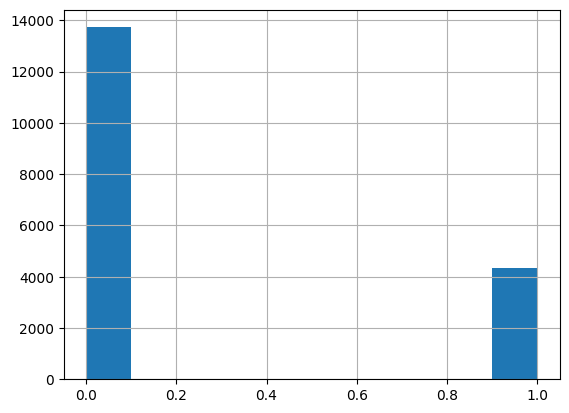

In [16]:
#labels: annotation of whether the post is hateful (== 1) or not (==0)
french_df['labels'].hist()

In [37]:
#keep non offensive columns
non_hate_french_text = french_df[french_df['labels'] == 0 ]
non_hate_french_text = non_hate_french_text[["text", "labels"]]
non_hate_french_text = non_hate_french_text.rename(columns={"labels": "hatespeech"})
non_hate_french_text = non_hate_french_text.reset_index(drop= True)
non_hate_french_text["language"] = "french"
non_hate_french_text["target"] = "not hate"
non_hate_french_text["directness"] = "normal"
non_hate_french_text["annotator_sentiment"] = "normal"
non_hate_french_text["group"] = "normal"

In [38]:
non_hate_french_text

,text,hatespeech,language,target,directness,annotator_sentiment,group
0,Alors julie t'ai dégeulasse de sortir avec un...,0,french,not hate,normal,normal,normal
1,allo mme est homophobe,0,french,not hate,normal,normal,normal
2,on est pas ensemble déjà puis même si c'était...,0,french,not hate,normal,normal,normal
3,laissé la tranquille elle n'est pas avec elle...,0,french,not hate,normal,normal,normal
4,mais assumer vous degouter bande de crasseuse,0,french,not hate,normal,normal,normal
...,...,...,...,...,...,...,...
13726,jâfrai jamais de trÃªve et tant pis si jâe...,0,french,not hate,normal,normal,normal
13727,@USER Le dernier tweet que jâai vu sur lui c...,0,french,not hate,normal,normal,normal
13728,"""@USER @USER @USER @USER Prcic suffit Ã mon b...",0,french,not hate,normal,normal,normal
13729,18h17 câest le moment parfait pour que les c...,0,french,not hate,normal,normal,normal


In [39]:
non_hate_french_text = non_hate_french_text.sample(n=5000, random_state=42)
non_hate_french_text = non_hate_french_text.reset_index(drop=True)

In [40]:
non_hate_ar_fr = pd.concat([non_hate_arabic_text, non_hate_french_text], ignore_index=True)
non_hate_ar_fr

,text,hatespeech,language,target,directness,annotator_sentiment,group
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0,arabic,not hate,normal,normal,normal
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0,arabic,not hate,normal,normal,normal
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0,arabic,not hate,normal,normal,normal
3,اي كذبه فيهم,0,arabic,not hate,normal,normal,normal
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0,arabic,not hate,normal,normal,normal
...,...,...,...,...,...,...,...
9995,"""@USER @USER @USER @USER ESPECE D'ENORME FILS ...",0,french,not hate,normal,normal,normal
9996,@USER sale richou,0,french,not hate,normal,normal,normal
9997,@USER @USER @USER @USER mael rentre pas dans l...,0,french,not hate,normal,normal,normal
9998,sans commentaire ....allemagne : les clans ara...,0,french,not hate,normal,normal,normal


# **Next Section: English dataset and language hate datasets**

In [41]:
# load datasets
ds_berekely_hate = load_dataset("ucberkeley-dlab/measuring-hate-speech")
ds_mlma_hate = load_dataset("nedjmaou/MLMA_hate_speech")

train_berekely_hate = ds_berekely_hate["train"]
train_mlma_hate = ds_mlma_hate["train"]

print(train_berekely_hate)
print(train_mlma_hate)

Dataset({
    features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target_gender_non_binary', 'target_

In [42]:
# FILTER NON-HATE SAMPLES
train_berkeley_hate_non_hate = train_berekely_hate.filter(
    lambda x: x["sentiment"] == 0
       and x["hatespeech"] == 0
       and x["hate_speech_score"] < 0
    )

print(f"Number of non-hate samples in Berkeley datset: {len(train_berkeley_hate_non_hate)}")
# print(train_berkeley_hate_non_hate["text"])

Number of non-hate samples in Berkeley datset: 9520


In [43]:
# Convert MLMA and Berkeley datasets to pandas DataFrames
mlma_df = train_mlma_hate.to_pandas().reset_index(drop=True)
berkeley_df = train_berkeley_hate_non_hate.to_pandas().reset_index(drop=True)

## Assign Language Column

In [44]:
# Assign language groups by row ranges
berkeley_df['language'] = 'english'

mlma_df['language'] = None
mlma_df.loc[:3352, 'language'] = 'arabic'      # 0 to 3352 (inclusive)
mlma_df.loc[3353:14646, 'language'] = 'english' # 3353 to 14646 (inclusive)
mlma_df.loc[14647:, 'language'] = 'french'      # 14647 to end

# Move 'language' to be the 3rd column
cols = list(mlma_df.columns)
cols.insert(2, cols.pop(cols.index('language')))
mlma_df = mlma_df[cols]

# Check the assignment
print(f"MLMA {mlma_df['language'].value_counts(dropna=False)}\n")
print(f"Berkeley {berkeley_df['language'].value_counts(dropna=False)}")

print(berkeley_df.columns)
print(mlma_df.columns)

MLMA language
english    11294
french      4014
arabic      3353
Name: count, dtype: int64

Berkeley language
english    9520
Name: count, dtype: int64
Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_jewish', 'annotator_religion_mormon',
       'annotator_religion_muslim', 'annotator_religion_nothing',
       'annotator_religion_other', 'annotator_sexuality_bisexual',
       'annotator_sexuality_gay', 'annotator_sexuality_straight',
       'annotator_sexuality_other', 'language'],
      dtype='object', length=132)
Index(['HITId', 'tweet', 'language', 'sentiment', 'directness',
       'annotator_sentiment', 'target', 'group'],
      dtype='object')


## Clean Columns and Merge

In [45]:
# Defining hate columns
berkeley_df['hatespeech'] = 0
mlma_df['hatespeech'] = 1

# Add an index column to Berkeley dataset called 'HITId' of incrementing ints
berkeley_df['HITId'] = range(len(berkeley_df))

# Set MLMA's 'tweet' column to its 'text' column (if not already)
mlma_df.rename(columns={'tweet': 'text'}, inplace=True)

# Set Berkeley's 'sentiment' column to 'normal'
berkeley_df['annotator_sentiment'] = 'normal'
mlma_df.drop(columns=['sentiment'], inplace=True)

# Add new columns to Berkeley with value 'normal'
for col in ['directness', 'annotator_sentiment', 'target', 'group']:
    berkeley_df[col] = 'normal'

# Filter Berkeley dataset for only columns in MLMA
filtered_berkeley_df = berkeley_df[['HITId', 'text', 'language', 'directness', 'annotator_sentiment', 'target', 'group', 'hatespeech']]

# Concatenate the two DataFrames
combined_df = pd.concat([mlma_df, filtered_berkeley_df], ignore_index=True) # ignore_index=True to create new index

print(combined_df.head())
print(combined_df.tail())
print(combined_df.shape)

   HITId                                               text language  \
0      1  صلاة الفجر خير لك من ترديد بول البعير وسبي الن...   arabic   
1      2  صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...   arabic   
2      3  طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...   arabic   
3      4  @user @user انا اوافقك بخصوص السوريين و العراق...   arabic   
4      5  هذه السعودية التي شعبها شعب الخيم و بول البعير...   arabic   

  directness                           annotator_sentiment  target  \
0   indirect                                         shock  gender   
1   indirect  anger_confusion_sadness_indifference_disgust   other   
2   indirect                                  indifference   other   
3     direct                                  indifference  origin   
4   indirect                                  indifference  origin   

        group  hatespeech  
0  individual           1  
1       other           1  
2  individual           1  
3       other           1  
4     

In [46]:
combined_df.columns

Index(['HITId', 'text', 'language', 'directness', 'annotator_sentiment',
       'target', 'group', 'hatespeech'],
      dtype='object')

In [47]:
combined_df

,HITId,text,language,directness,annotator_sentiment,target,group,hatespeech
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,arabic,indirect,shock,gender,individual,1
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,arabic,indirect,anger_confusion_sadness_indifference_disgust,other,other,1
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,arabic,indirect,indifference,other,individual,1
3,4,@user @user انا اوافقك بخصوص السوريين و العراق...,arabic,direct,indifference,origin,other,1
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير...,arabic,indirect,indifference,origin,other,1
...,...,...,...,...,...,...,...,...
28176,9515,"Please help support nonbinary pride, add a #Tw...",english,normal,normal,normal,normal,0
28177,9516,I love that you enjoy being trans.,english,normal,normal,normal,normal,0
28178,9517,I've always been proud of the Igbo tribe and o...,english,normal,normal,normal,normal,0
28179,9518,Trans rights are human rights,english,normal,normal,normal,normal,0


In [48]:
MLMA_eng_target_variables = combined_df[["text", "language", "target", "hatespeech", "directness", "annotator_sentiment", "group"]]

In [49]:
hate_detect = pd.concat([non_hate_ar_fr, MLMA_eng_target_variables ], ignore_index=True)
hate_detect

,text,hatespeech,language,target,directness,annotator_sentiment,group
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0,arabic,not hate,normal,normal,normal
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0,arabic,not hate,normal,normal,normal
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0,arabic,not hate,normal,normal,normal
3,اي كذبه فيهم,0,arabic,not hate,normal,normal,normal
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0,arabic,not hate,normal,normal,normal
...,...,...,...,...,...,...,...
38176,"Please help support nonbinary pride, add a #Tw...",0,english,normal,normal,normal,normal
38177,I love that you enjoy being trans.,0,english,normal,normal,normal,normal
38178,I've always been proud of the Igbo tribe and o...,0,english,normal,normal,normal,normal
38179,Trans rights are human rights,0,english,normal,normal,normal,normal


In [50]:
#hate_detect.to_csv("hate_detect_tweets.csv", index=False)
hate_detect.to_csv("/content/drive/MyDrive/hate_detect_tweets.csv", index=False)